# Introduction

In this program, I examine the use of machine learning to identify the sentiment of a Yelp review. The sentiment ranges from strongly positive to strongly negative. The yelp data is pre-processed to handle duplicate and other unwanted texts and values. Once the data is pre-processed, I construct a neural network using the LSTM-CNN architecture. The accuracy of the final model is 64.4%.


# Google Colab Setup

In [0]:


import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
!pip install swifter
import itertools
import swifter
import re

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV as randsearch

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding , SpatialDropout1D, Dense, LSTM,\
MaxPooling1D,Bidirectional, Dropout, Conv1D, Flatten, BatchNormalization


  Stored in directory: /root/.cache/pip/wheels/d9/e9/d9/16e18f658c4f82563ccc01d8518933409be6416c445be5cfa6
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built swifter locket


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Setup for GPU preprocessing

In [0]:
!nvidia-smi
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if device_name != b'Tesla T4':
  raise Exception("""
    Unfortunately this instance does not have a T4 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4. Resetting the instance.

    If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)
else:
  print('Woo! You got the right kind of GPU!')
  


Fri May 31 10:36:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# intall miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# install RAPIDS packages
!conda install -q -y --prefix /usr/local -c conda-forge \
  -c rapidsai-nightly/label/cuda10.0 -c nvidia/label/cuda10.0 \
  cudf cuml

# set environment vars
import sys, os, shutil
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# copy .so files to current working dir
for fn in ['libcudf.so', 'librmm.so']:
  shutil.copy('/usr/local/lib/'+fn, os.getcwd())

--2019-05-31 10:36:39--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   128MB/s    in 0.4s    

2019-05-31 10:36:39 (128 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-

In [0]:

import nvstrings, nvcategory, cudf
import io, requests

# Import Files


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_path = "/content/drive/My Drive/data/train_data.csv"
label_path = "/content/drive/My Drive/data/train_label.csv"


In [0]:
pd_train = pd.read_csv(train_path,encoding='utf-8')
pd_label = pd.read_csv(label_path)
pd_test = pd.read_csv(test_path)

# Preprocessing



The preprocessing stages for the dataset is as follows:

Step 1: Removal of duplicates
Duplicate reviews were removed. This reduced the number of reviews from 650,00 to 649,050. 
 
Step 2: Case normalisation
Strings were converted to all lowercase so same words with different cases will be recognized by the modelling algorithm.
 
Step 3: Expanding Negative Contractions
Negative contractions such as can’t and shouldn’t were expanded to can not and should not, for better recognition of negative sentiment.
 
Step 4: Removing Punctuation
Punctuation was removed except for period (.), exclamation mark (!) and question mark (?) as these may provide valuable information towards sentiment. For example, “the meal was good.” may have a different interpretation to “the meal was good!”. A space was added before and after these special punctuations, so they may be individually regarded as a feature.
 
Step 5: Removing Digits 
Digits were removed.
 
Step 6: Removing Characters
Consecutive repeated characters were removed to improve the likelihood of different spellings of the same word be converted to the same format. For example, “the service was soooo goooood” would become “the service was so good”. This way both “gooood” and “good” would count as the same feature.
 
Step 7: Stemming
The words were stemmed to again increase the likelihood of similar words with different conjugations counting as the same feature. For example, both “amazing” and “amazed” will be stemmed to “amaz”.

Step 8: Tokenization
The strings were converted to tokens and then to integer values, which is the input format the model accepts.


In [0]:
# drop duplicates


pd_train.drop_duplicates("text",keep= "first", inplace= True)

pd_label = pd_label.loc[pd_train.index]



In [0]:

punct_list = ['\-', '\:', ':', '&', '\'', ',','\$', '\^','"','\*','\n', '\r',\
              '\(', '\)',';', '%', '\#', '\+','/']

digit_list = [1,2,3,4,5,6,7,8,9,0]

alphas = "abcdefghijklmnopqrstuvwxyz"

def remove_punctuation(nvstring_object, punctuation_list = punct_list, num_batches=5):
    split_punct_list = np.array_split(punctuation_list, num_batches)

    for chunk in split_punct_list:
        combined_regex = '|'.join(['({0})'.format(x) for x in chunk])
        nvstring_object = nvstring_object.replace(combined_regex, ' ', regex=True)
        
    print("done")
    return nvstring_object
    
def remove_repeat_chars(nvstring_object, alphabets = alphas):
    for alpha in alphabets:
        combined_regex = '{0}'.format(alpha)+'{2,}'
        nvstring_object = nvstring_object.replace(combined_regex, alpha, regex=True)
      
    print("done")
    return nvstring_object
  
def remove_digits(nvstring_object, digits = digit_list, num_batches=4):
  split_digit_list = np.array_split(digits, num_batches)
  for chunk in split_digit_list:
      combined_regex = '|'.join(['({0})'.format(str(x)) for x in chunk])
      nvstring_object = nvstring_object.replace(combined_regex, '', regex=True)
      
  print("done")
  return nvstring_object

def preprocess(data, batches=5):
    #convert to nvstring for GPU processing
    nvstring_object = nvstrings.to_device(list(data))
    """Preprocess nvstrings
    """
    # lowercase and strip
    nvstring_object = nvstring_object.lower()
    nvstring_object = nvstring_object.strip()
    
    print("done")
    #   preserve negative contractions

    nvstring_object = nvstring_object.replace("n't", ' not')
    
    print("done")
    
    # remove punctuation  

    nvstring_object = remove_punctuation(nvstring_object)
    
    # remove digits
    nvstring_object = remove_digits(nvstring_object)
      
    # remove repeat characters
    nvstring_object = remove_repeat_chars(nvstring_object)
   
    
    print("done")
        
    return nvstring_object

In [0]:

stem = PorterStemmer().stem
def stemmer(x):
  words = x.split(" ")
  x = [stem(word) for word in words if word!=""]
  x = " ".join(x)
  return x

In [0]:
text = preprocess(pd_train.text, batches = 25).to_host()

# stem data text

partitions = np.array_split(pd.Series(text),5)

for i, x in enumerate(partitions):
   partitions[i] = pd.Series(partitions[i]).swifter.apply(stemmer)
    
df = pd_train

df.text = list(itertools.chain.from_iterable(partitions))

# make special punctuation invidiual features

df.text = df.text.str.replace("?", ' ? ')

df.text = df.text.str.replace('.', ' . ')

df.text = df.text.str.replace('!', ' ! ')

There was a big spread in the review length. The median length was 106 features

{'boxes': [<matplotlib.lines.Line2D at 0x7fb47b3a9198>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb47b3a9978>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb47b3a0390>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb47b3a0048>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb47b3a9320>,
  <matplotlib.lines.Line2D at 0x7fb47b3a9630>]}

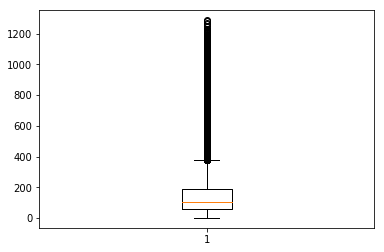

In [0]:
rev_length = df.text.apply(lambda x: len(x.split(" ")))
plt.boxplot(rev_length)

In [0]:
rev_length.describe()

count    649050.000000
mean        145.440646
std         130.108981
min           1.000000
25%          60.000000
50%         106.000000
75%         186.000000
max        1287.000000
Name: text, dtype: float64

In [0]:
# Max number of words in each complaint.
max_seq_length = 400

# build vocab
tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(df.text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# tokenize reviews
token_ids = tokenizer.texts_to_sequences(df.text.values)

# make all sequence equal length
padded_token_ids = pad_sequences(token_ids, maxlen=max_seq_length)
print('Shape of data tensor:', padded_token_ids.shape)

Found 159505 unique tokens.
Shape of data tensor: (649050, 400)


#Model 

TPU hardware

In [0]:
import sys, os, shutil
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

Found TPU at: grpc://10.47.111.74:8470


LSTM’s can be useful for this problem as it accepts sequences as its input. The model is able to slide along the sequence, while remembering previous inputs to model context and determine how that affects the output.  For example, if we have a review that says “ This place was great but not anymore”, as the LSTM model slides across the sequence it can learn that the latter part of the sequence “but not anymore” is more reflective of the output than the first part, “this place was great”. Once the LSTM outputs the sections of the sequence with the most value, the CNN can then be used to identify what part of the sequence is the most important towards the output. In our case, were the LSTM model to output not anymore” the CNN may then decide “not” and “anymore” are the most important in determining the output.

The model works by updating the weights of each node in the network after each pass (epoch) of the data so as to minimize the prediction error.
The neural network is constructed as followed:
* Embedding layer - converts sequences into an embedding which is a vector such that words with similar context have similar values
* LSTM layer
* Dropout - penalize overfitting
* CNN layer
* Max Pooling layer - reduces dimensionality of CNN layer and extract most valuable features
* Hidden Layer - collects results and apply an activation function to determine which nodes need to be “switched off or on”.  
* Batch Normalization - penalize overfitting


In [0]:
# create our nueral network model

def create_model(embedding_dim, dropout, recurrent_dropout, dense_dim, filters, kernel, pool_size):
    # create model
    model = Sequential()
    model.add(Embedding(len(word_index)+1,embedding_dim, input_length= X.shape[1]))
    model.add(LSTM(embedding_dim, dropout = dropout, recurrent_dropout= recurrent_dropout,return_sequences= True))
    model.add(Conv1D(filters, kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size= pool_size))
    model.add(Flatten())
    model.add(Dense(dense_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        )
    )

    tpu_model.compile(
        optimizer=tf.train.AdamOptimizer(),
        loss= "categorical_crossentropy",
        metrics=['accuracy']
    )
    # Compile model
    return tpu_model

In the cell below we sample the dataset to perform a random search

In [0]:
df= pd.DataFrame(zip(df.text,pd_label.label), columns=["text","label"])
sample = df.sample(60000,weights=df.label, random_state = 42)

df = df[df.index.isin(sample.index)==False]

X = pad_sequences(tokenizer.texts_to_sequences(sample.text.values), maxlen=max_seq_length)
Y = pd.get_dummies(sample.label).values

To find the optimal parameter values, Random Search was used with 3-fold cross validation and 10 iterations to compare the accuracy of models with a subset of the dataset. Due to time cost, the random search was performed only on a subset of 60,000 rows from the dataset. This reduces the probability of the selected parameter values as being optimal.

In [0]:


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
# split into input (X) and output (Y) variables

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the rand search parameters
batch_size = [20, 40, 60, 80, 100, 200]
embedding_dim = [10, 50, 100, 200]
dropout = [0.2,0.4,0.6,0.8]
recurrent_dropout = [0.2,0.4,0.6,0.8]
dense_dim = [32,64,128,256]
filters = [20, 50, 100, 150 ]
kernel = [2,3,4,5]
pool_size = [2,3,4,5]
param_dist = dict(batch_size=batch_size, embedding_dim = embedding_dim\
                  , dropout = dropout, recurrent_dropout = recurrent_dropout,\
                  dense_dim = dense_dim, filters = filters, kernel = kernel, pool_size = pool_size)

# perform random search with 3 fold CV
rand = randsearch(estimator=model, param_distributions=param_dist, cv=3)
rand_result = rand.fit(X, Y)
# summarize results
print("Best: %f using %s" % (rand_result.best_score_, rand_result.best_params_))
means = rand_result.cv_results_['mean_test_score']
stds = rand_result.cv_results_['std_test_score']
params = rand_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.99.31.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15203511291623056156)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15267895023600141773)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 172

In [0]:
params = {'batch_size': 80,
 'dense_dim': 32,
 'dropout': 0.2,
 'embedding_dim': 100,
 'filters': 20,
 'kernel': 3,
 'pool_size': 4,
 'recurrent_dropout': 0.4}

params

{'batch_size': 80,
 'dense_dim': 32,
 'dropout': 0.2,
 'embedding_dim': 100,
 'filters': 20,
 'kernel': 3,
 'pool_size': 4,
 'recurrent_dropout': 0.4}

In [0]:
# get padded sequences for dataset without the sample
padded_token_ids = pad_sequences(tokenizer.texts_to_sequences(df.text.values), maxlen=max_seq_length)

# convert labels to one-hot encoded
labels = pd.get_dummies(df.label).values

#split train, test data
X_Train,X_Test, Y_Train, Y_Test = train_test_split(padded_token_ids,labels, test_size = 0.20, random_state= 43, stratify = labels)

# make training dataset fully divisible by batch size for the model
rows = (X_Train.shape[0]//80)*80

X_Train = X_Train[:rows]
Y_Train = Y_Train[:rows]


In [0]:
def create_model(embedding_dim, dropout, recurrent_dropout, dense_dim, filters, kernel, pool_size):
    # create model
    model = Sequential()
    model.add(Embedding(len(word_index)+1,embedding_dim, input_length= X_Train.shape[1]))
    model.add(LSTM(embedding_dim, dropout = dropout, recurrent_dropout= recurrent_dropout,return_sequences= True))
    
    model.add(Conv1D(filters, kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size= pool_size))
    model.add(Flatten())
    model.add(Dense(dense_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    
    # use TPU processing for model
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        )
    )
    # compile model
    tpu_model.compile(
        optimizer=tf.train.AdamOptimizer(),
        loss= "categorical_crossentropy",
        metrics=['accuracy']
    )
    return tpu_model

In [0]:
# create network 
cnn_lstm = create_model(params["embedding_dim"], params["dropout"], params["recurrent_dropout"], params["dense_dim"], params["filters"], params["kernel"], params["pool_size"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.47.111.74:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13308578725842643612)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6565286688777114371)
INFO:tensorflow:*** Available Device: _DeviceAtt

In [0]:
# fit network to training data
history = cnn_lstm.fit(X_Train, Y_Train, epochs=10, batch_size=params["batch_size"],validation_data=(X_Test, Y_Test),\
                        callbacks=[EarlyStopping(monitor='val_acc', patience=7, min_delta=0, mode ="auto"),\
                                  ModelCheckpoint('/content/drive/My Drive/data/test/model_cnn_lstm.h5', monitor='val_acc', \
                                                  verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)])

Train on 471200 samples, validate on 117810 samples
Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(10,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(10, 400), dtype=tf.float32, name='embedding_input_10'), TensorSpec(shape=(10, 5), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for embedding_input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.381927967071533 secs
INFO:tensorflow:Setting weights on TPU model.
471120/471200 [============================>.] - ETA: 0s - loss: 0.9953 - acc: 0.5741INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(10,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(10, 400), dtype=tf.float32, name='embedding_input_10'), Tenso

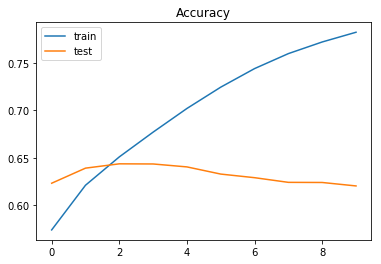

In [0]:
# plot to check for overfitting
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

The highest accuracy was achieved at the third epoch.  Afterwards, the model begins to overfit the data.

The final prediction accuracy is 64.4%.

# References

“Twitter Sentiment Analysis Using Combined LSTM-CNN Models.” Bsides, konukoii.com/blog/2018/02/19/twitter-sentiment-analysis-using-combined-lstm-cnn-models/.

“LSTMs” Adventures in Machine Learning, adventuresinmachinelearning.com/category/deep-learning/lstms/.